# uvfmeas fitting

Making sure I can copy the results of uvfmeas

Output for 2018-07-01

```
uvfmeas% vis=f7700/0327-241.7700 
uvfmeas% inp
  Task:   uvfmeas
  vis      = f7700/0327-241.7700
  select   =  
  line     =  
  stokes   = i
  hann     =  
  offset   =  
  order    = 1
  options  = log,mfflux
  yrange   =  
  device   = 1/xs
  nxy      =  
  log      =  
  fitp     =  
  feval    = 8.5
uvfmeas% go

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC                         'WX
Applying bandpass corrections to f7700/0327-241.7700
Applying freq. dependent gain corrections to f7700/0327-241.7700
Applying freq. dependent leakage correction to f7700/0327-241.7700
Source: 0327-241
Stokes I
Vector Average Amplitude:   9.933E-01         Phase:  -4.377E-03
             Uncertainty:   2.850E-02
Scalar Average Amplitude:   9.951E-01   Uncertainty:   2.893E-02
Scalar Average Fit Coefficients:
 log S =   1.141E-01
       +  -1.314E-01 x (log f)^ 1
MFCAL flux= 1.0276,  6.0,-0.1314
Flux density at   8.500 GHz =   0.9817 Jy.
Scatter around fit:   2.887E-03
Reduced chi squared:   5.169E-09
--------------------------------------------------------------------------------
```

In [1]:
% matplotlib inline
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import curve_fit

In [3]:
df7 = pd.read_csv(f'../Data/2018-07-01/Plots/secondary_uvfmeas_7700_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)
df9 = pd.read_csv(f'../Data/2018-07-01/Plots/secondary_uvfmeas_9500_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)

nu7, snu7 = np.log10(df7['nu'].values), np.log10(df7['s_nu'].values)
nu9, snu9 = np.log10(df9['nu'].values), np.log10(df9['s_nu'].values)

In [4]:
def poly(nu, *p):
    spec = np.zeros_like(nu)
    for index, val in enumerate(p):
        spec += val * nu ** index
    
    return spec

In [5]:
ref_nu = np.log10(6.)

fit7 = curve_fit(poly, nu7-ref_nu, snu7, (1., -0.7))
fit9 = curve_fit(poly, nu9-ref_nu, snu9, (1., -0.7))

In [6]:
fit7


(array([ 0.01177484, -0.13082201]),
 array([[  1.20629703e-08,  -1.04423848e-07],
        [ -1.04423848e-07,   9.81222126e-07]]))

In [7]:
a1=fit7[0][1]
print(a1)

-0.13082201133


In [8]:
10**fit7[0][0]

1.0274834672167843

In [9]:
fit9

(array([ 0.017434  , -0.14619586]),
 array([[  5.81226588e-08,  -2.87558841e-07],
        [ -2.87558841e-07,   1.44462243e-06]]))

In [10]:
100**fit9[0][0]

1.0835975166860978

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


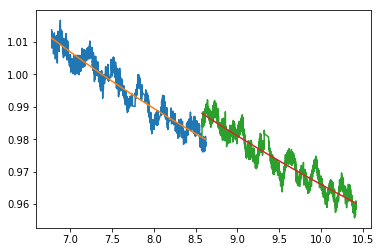

In [57]:
fig, ax = plt.subplots(1,1)

ax.plot(10.**nu7, 10.**snu7)
ax.plot(10.**nu7, 10.**poly(nu7-ref_nu, *fit7[0]))

ax.plot(10.**nu9, 10.**snu9)
ax.plot(10.**nu9, 10.**poly(nu9-ref_nu, *fit9[0]))

fig.show()

In [58]:
fact = fit7[0][0] - fit9[0][0]
print(fact)

-0.00333359187033


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


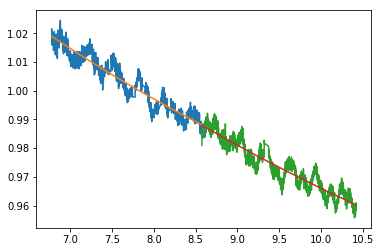

In [59]:
fig, ax = plt.subplots(1,1)

ax.plot(10.**nu7, 10.**(snu7-fact))
ax.plot(10.**nu7, 10.**(poly(nu7-ref_nu, *fit7[0])-fact))

ax.plot(10.**nu9, 10.**snu9)
ax.plot(10.**nu9, 10.**poly(nu9-ref_nu, *fit9[0]))

fig.show()

In [60]:
def mfcal_flux(fit, ifcal=1):
    nu_0 = fit[2]
    fact = fit[3]

    if ifcal == 1:
        flux_str = f"{10.**(fit[0][0]+fact):.4f},{nu_0:.1f},{fit[0][1]:.4f}"
    else:
        flux_str = f"{10.**fit[1][0]:.4f},{nu_0:.1f},{fit[1][1]:.4f}"
        
    return flux_str

def pl(nu, *p):
    """Polynomial model to fit to spectra. To be consistent
    with uvfmeas options=log, data should be logged when given
    to the fitting method (i.e. curve_fit)
    
    Arguments:
        nu {numpy.ndarray} -- Frequency of the data. Divide data by nu_0 outsid eof method
    
    Returns:
       spec {numpy.ndarray} -- Modelled spectrum
    """
    spec = np.zeros_like(nu)
    for index, val in enumerate(p):
        spec += val * nu ** index

    return spec

def model_secondary(plot=False, nu_0=8.5):
    """Function to scale IF1 onto IF2. 

    Assumes that it is being called from a `Date` folder with an
    initial calibration
    """

    df7 = pd.read_csv(f'../Data/2018-07-01/Plots/secondary_uvfmeas_7700_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)
    df9 = pd.read_csv(f'../Data/2018-07-01/Plots/secondary_uvfmeas_9500_log.txt', names=('nu','s_nu','s_model'), delim_whitespace=True)
    
    nu7, snu7 = np.log10(df7['nu'].values/nu_0), np.log10(df7['s_nu'].values)
    nu9, snu9 = np.log10(df9['nu'].values/nu_0), np.log10(df9['s_nu'].values)

#     nu7, snu7 = np.log(df7['nu'].values/nu_0), np.log(df7['s_nu'].values)
#     nu9, snu9 = np.log(df9['nu'].values/nu_0), np.log(df9['s_nu'].values)

    
    fit7 = curve_fit(pl, nu7, snu7, (1., -0.7))
    fit9 = curve_fit(pl, nu9, snu9, (1., -0.7))
    
#     fact = fit7[0][0] - fit9[0][0]
#     fact = 0
    nom7 = np.median(pl(nu7[-50:], *fit7[0]))
    nom9 = np.median(pl(nu9[:50], *fit9[0]))
    fact = nom7 - nom9

    print(nom7, nom9)
    print(10.**nom7, 10.**nom9)
    
    if plot:
        fig, (ax,ax1) = plt.subplots(2,1, figsize=(10,8))

        ax.plot(10**nu7, 10**snu7)
        ax.plot(10**nu7, 10**pl(nu7, *fit7[0]))

        ax.plot(10**nu9, 10**snu9)
        ax.plot(10**nu9, 10**pl(nu9, *fit9[0]))

        ax1.plot(10**nu7, 10**(snu7-fact))
        ax1.plot(10**nu7, 10**(pl(nu7, *fit7[0])-fact))

        ax1.plot(10**nu9, 10**snu9)
        ax1.plot(10**nu9, 10**pl(nu9, *fit9[0]))

        fig.show()
    
    return (fit7[0], fit9[0], nu_0, fact)

-0.00866229415332 -0.00543438582631
0.980251929547 0.987564827961


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


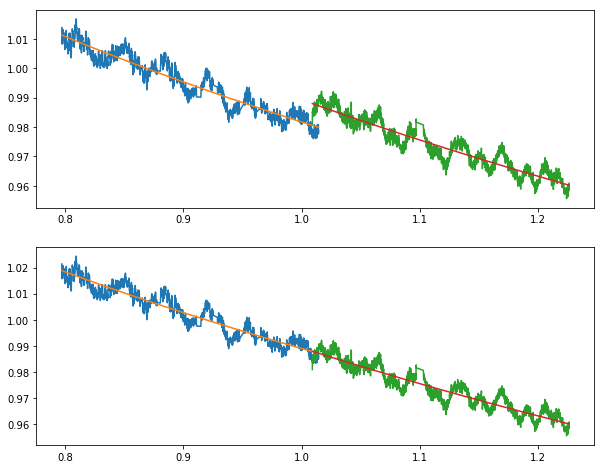

In [61]:
fit = model_secondary(plot=True)

In [62]:
fit

(array([-0.0080143 , -0.13082201]),
 array([-0.00468071, -0.14619586]),
 8.5,
 -0.003227908327005531)

In [63]:
mfcal_flux(fit, ifcal=1)

'0.9744,8.5,-0.1308'

In [64]:
mfcal_flux(fit, ifcal=2)

'0.9893,8.5,-0.1462'

In [65]:
10.**snu9[0]

0.98098390000000002

In [66]:
10**fit9[0][0]

0.98928014520020124

In [67]:
10.**pl(nu9[0],*fit9[0])

0.72255268864176136

In [68]:
10.**nu7[-50:]

array([ 8.572,  8.573,  8.574,  8.575,  8.576,  8.577,  8.578,  8.579,
        8.58 ,  8.581,  8.582,  8.583,  8.584,  8.585,  8.586,  8.587,
        8.588,  8.589,  8.59 ,  8.591,  8.592,  8.593,  8.594,  8.595,
        8.597,  8.598,  8.599,  8.6  ,  8.601,  8.602,  8.603,  8.604,
        8.605,  8.606,  8.607,  8.608,  8.609,  8.61 ,  8.611,  8.612,
        8.613,  8.614,  8.615,  8.616,  8.617,  8.618,  8.619,  8.62 ,
        8.621,  8.622])

In [69]:
10.**nu9[:50]

array([ 8.577,  8.578,  8.579,  8.58 ,  8.581,  8.582,  8.583,  8.584,
        8.585,  8.586,  8.587,  8.588,  8.589,  8.59 ,  8.591,  8.592,
        8.593,  8.594,  8.595,  8.596,  8.597,  8.598,  8.599,  8.6  ,
        8.601,  8.602,  8.603,  8.605,  8.606,  8.607,  8.608,  8.609,
        8.61 ,  8.611,  8.612,  8.613,  8.614,  8.615,  8.616,  8.617,
        8.618,  8.619,  8.62 ,  8.621,  8.622,  8.623,  8.624,  8.625,
        8.626,  8.627])